In [1]:
import os
import gc
import glob
import tqdm
import hdf5plugin
import pandas as pd
import numpy as np
import scanpy as sc
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.sparse import issparse
from PIL import Image
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr, spearmanr
from PIL import Image
Image.MAX_IMAGE_PIXELS = None

In [2]:
%cd ~/Q2051/DeepHis2Exp/

/afm03/Q2/Q2051/DeepHis2Exp


In [3]:
# Breast cancer BC_visium dataset
dataset_name = "BC_visium"
adata_path = glob.glob("./Dataset/BC_visium/*h5ad")[:-1]
# target_gene_list = np.load("../Dataset/Gene_list/Gene_list_func_BC_visium.npy").tolist()
# target_gene_list = None
adata_dict = {i.split("/")[-1].split(".")[0]: sc.read_h5ad(i) for i in adata_path}

In [4]:
# Compute QC metrics
for i in range(len(list(adata_dict.keys()))):
    sc.pp.calculate_qc_metrics(adata_dict[list(adata_dict.keys())[i]], log1p=False, inplace=True)

# Plot QC metrics n_genes_by_counts
df = []
for i in range(len(list(adata_dict.keys()))):
    x = adata_dict[list(adata_dict.keys())[i]].obs[["n_genes_by_counts"]]
    x["Slide"] = list(adata_dict.keys())[i]
    df.append(x)
df = pd.concat(df)

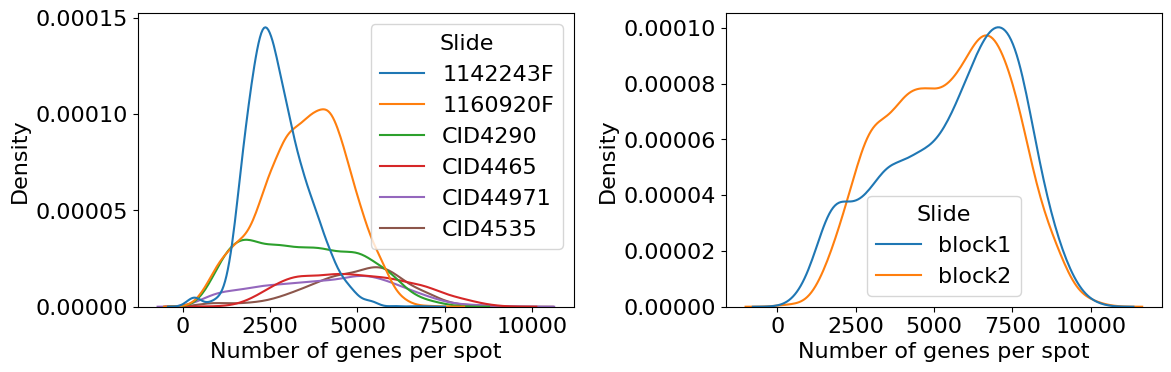

In [5]:
df["Number of genes per spot"] = df["n_genes_by_counts"]
df_alex = df[~df["Slide"].isin(["block1", "block2"])]
df_alex = df_alex.sort_values("Slide")
df_10x = df[df["Slide"].isin(["block1", "block2"])]
df_10x = df_10x.sort_values("Slide")

plt.rcParams.update({'font.size': 16})
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plotting the first subplot
sns.kdeplot(df_alex, x="Number of genes per spot", hue="Slide", ax=axs[0])

# Plotting the second subplot
sns.kdeplot(df_10x, x="Number of genes per spot", hue="Slide", ax=axs[1])

plt.tight_layout()

In [6]:
df_10x['Dataset'] = '10x'

In [7]:
df_alex['Dataset'] = 'Wu'

In [21]:
!cp ./ID_expression_detection.pdf ~/scratch/tmp

4025

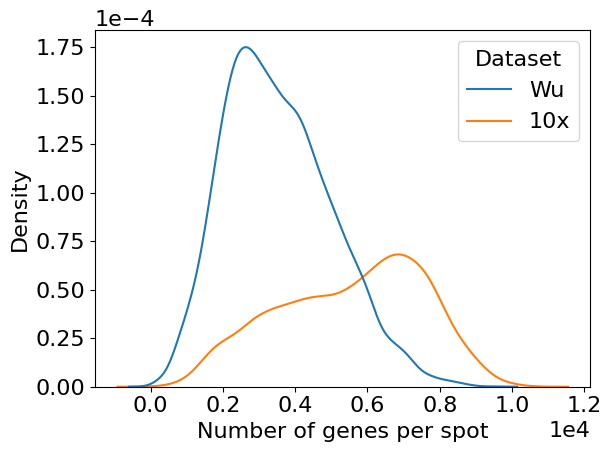

In [9]:
sns.kdeplot(pd.concat((df_alex,df_10x)), x="Number of genes per spot", hue='Dataset')
plt.ticklabel_format(axis='both', style='scientific', scilimits=(0, 0))
plt.tight_layout()
# plt.savefig("ID_expression_detection.pdf", dpi=300)
gc.collect()

In [11]:
# List of file paths for your 6 images
names = [i.split("/")[-1].split(".")[0] for i in adata_path]
image_paths = [f"./Dataset/BC_visium/{name}/image.tif" for name in names]

images = []
for image_path in image_paths:
    img = np.array(Image.open(image_path))
    images.append(img)

R, G, B = {}, {}, {}
for i in range(len(names)):
    name = names[i]
    R[name+"_mean"] = images[i][:,:,0].mean()
    G[name+"_mean"] = images[i][:,:,1].mean()
    B[name+"_mean"] = images[i][:,:,2].mean()

df = pd.concat([pd.DataFrame(R, index=["Red"]),
                pd.DataFrame(G, index=["Green"]),
                pd.DataFrame(B, index=["Blue"]),
               ]).T
df["Slide"] = names

# Melt the DataFrame
melted_df = pd.melt(df, id_vars=['Slide'], var_name='Color', value_name='Mean Value')

# Display the melted DataFrame
# melted_df

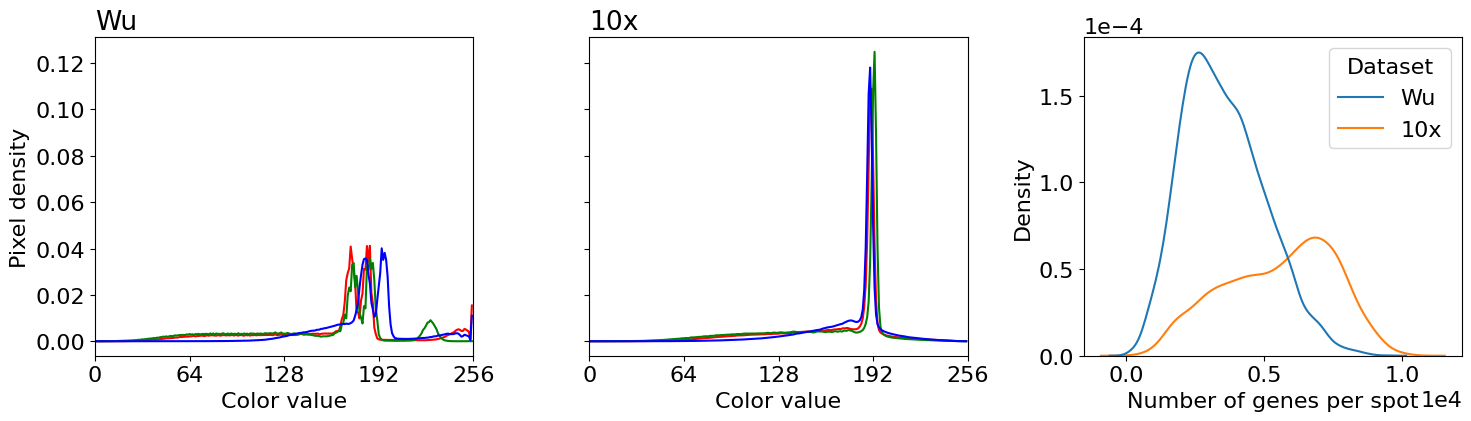

In [35]:
colors = ("red", "green", "blue")

# fig, ax = plt.subplots(ncols=3,sharex='all',sharey='all', figsize=(15,4.5))
fig, ax = plt.subplots(ncols=3,figsize=(15,4.5))
ax[0].set_xlim([0, 256])
ax[1].set_xlim([0, 256])
for channel_id, color in enumerate(colors):
    histogram, bin_edges = np.histogram(
        np.concatenate((images[0].reshape((-1,3)),images[1].reshape((-1,3)),
                       images[2].reshape((-1,3)),images[3].reshape((-1,3)),
                       images[4].reshape((-1,3)),images[-1].reshape((-1,3))), axis=0)[:, channel_id], bins=256, range=(0, 256), density=True
    )
    ax[0].plot(bin_edges[0:-1], histogram, color=color)
    histogram, bin_edges = np.histogram(
        np.concatenate((images[-2].reshape((-1,3)),images[-3].reshape((-1,3))), axis=0)[:, channel_id], bins=256, range=(0, 256), density=True
    )
    ax[1].plot(bin_edges[0:-1], histogram, color=color)


ax[0].set_title("Wu", loc='left')
ax[1].set_title("10x", loc='left')
# ax[1].set_xlabel("Color value")
ax[1].sharey(ax[0])
[label.set_visible(False) for label in ax[1].get_yticklabels()]
ax[0].set_xticks([0, 64, 128, 192, 256])
ax[1].set_xticks([0, 64, 128, 192, 256])
# ax[0].set_yticklabels([])
ax[0].set_xlabel("Color value")
ax[1].set_xlabel("Color value")

ax[0].set_ylabel("Pixel density")


sns.kdeplot(pd.concat((df_alex,df_10x)), x="Number of genes per spot", hue='Dataset', ax=ax[2])
ax[2].ticklabel_format(axis='both', style='scientific', scilimits=(0, 0))
# plt.tight_layout()


fig.tight_layout()
# fig.supxlabel('Color value',y=0)
plt.savefig('colplot2.pdf')